<a href="https://colab.research.google.com/github/maurosc3ner/ml_python_playground/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/time_series_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and helpers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Let's create to simulate time series data:

In [7]:
# helper for plotting
def plot_Series(time,series, format="-",start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end],format,label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

#helper for global trend
def trend(time,slope=0):
  return slope*time

# helper for seasonal (e.g., periodic patter until 40%, then inverse of exponential)
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*3*np.pi),
                  1/np.exp(2*season_time))

# period : how ofter the pattern is repeated
# amplitude : the width of the parent
# phase : the right shift
def seasonality(time,period,amplitude=1,phase=0):
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time, noise_level=1, seed=42):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

Use the aforementioned function and checking the simulated data:

[   0    1    2 ... 1458 1459 1460]
[ 10.   10.1  10.2 ... 155.8 155.9 156. ]


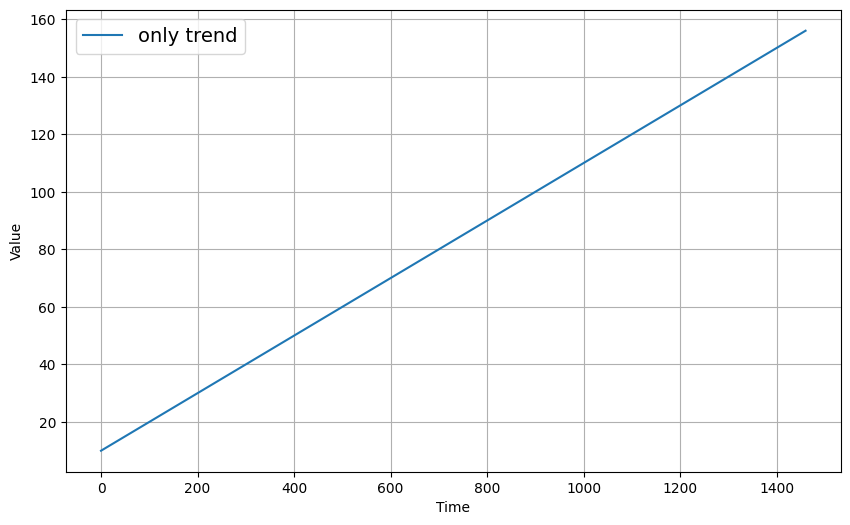

In [3]:
# Only trend
time=np.arange(4*365+1)
baseline=10
series=baseline+trend(time,0.1)
print(time)
print(series)
plt.figure(figsize=(10,6))
plot_Series(time,series,label="only trend")
plt.show()

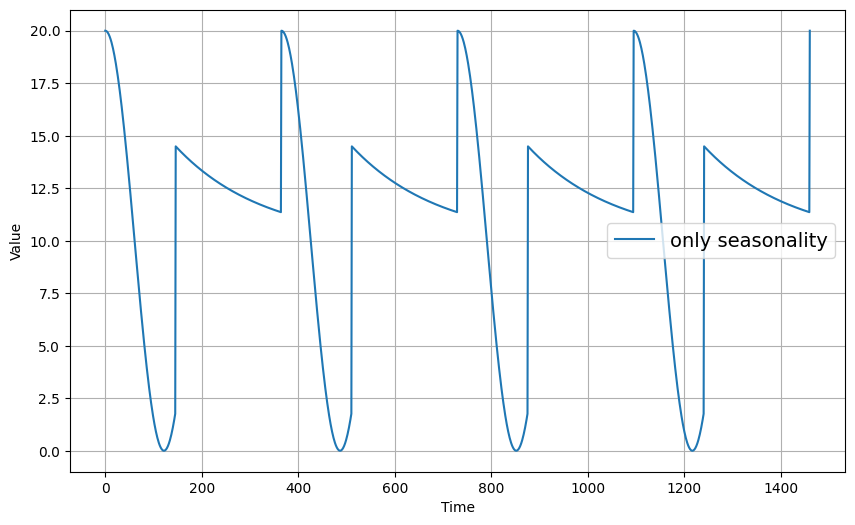

In [5]:
# only seasonality
amplitude = 10
series = baseline+seasonality(time, period=365, amplitude=amplitude)
plt.figure(figsize=(10, 6))
plot_Series(time, series,label="only seasonality")
plt.show()

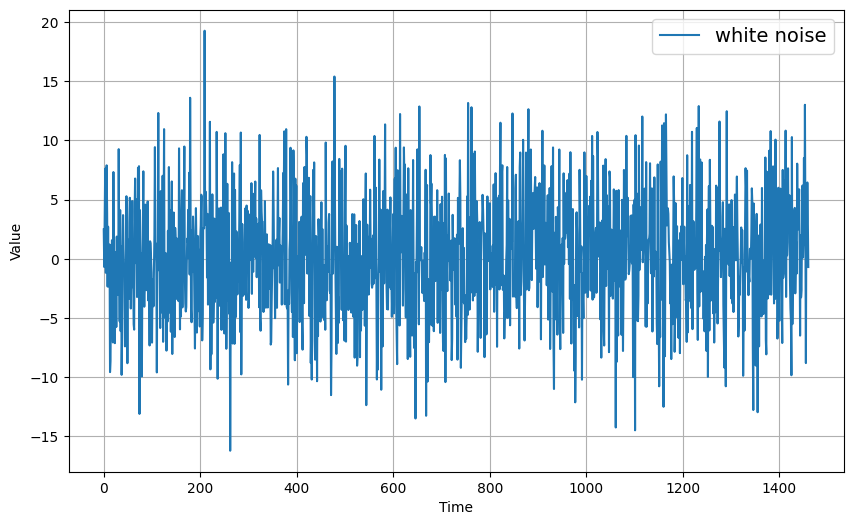

In [6]:
#Only noise
noise_level = 5
noise = white_noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_Series(time, noise,label="white noise")
plt.show()

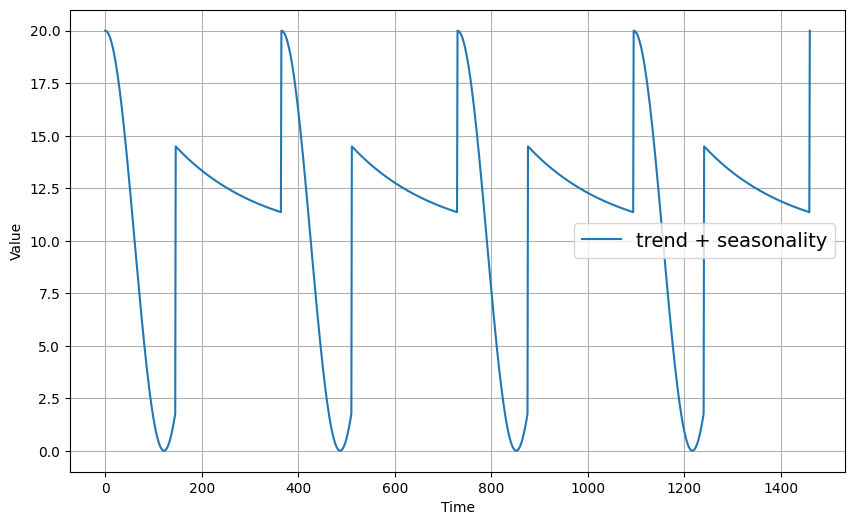

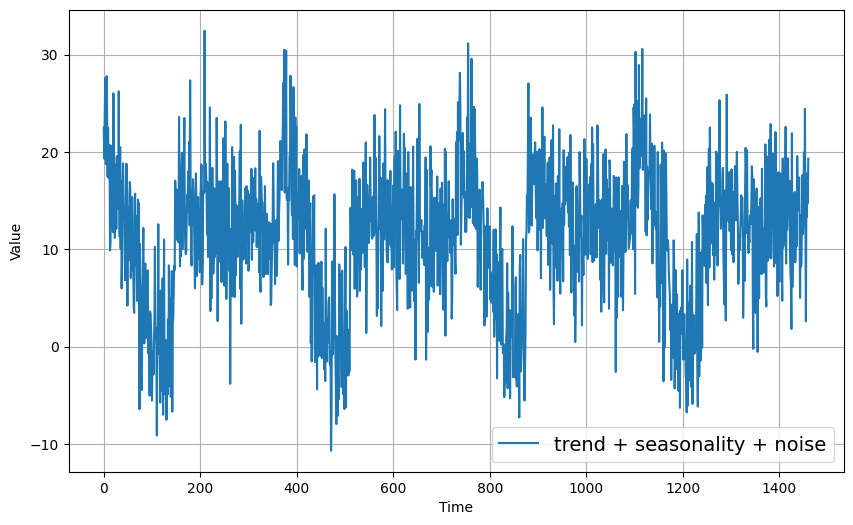

In [10]:
# trend+seasonality
slope = 0
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plt.figure(figsize=(10, 6))
plot_Series(time, series,label="trend + seasonality")
plt.show()

# All together
series += noise
plt.figure(figsize=(10, 6))
plot_Series(time, series,label="trend + seasonality + noise")
plt.show()

# Heuristic version


There are two ways to partitioning time series data:
* Fixed as classic ML approaches (training, validation, test period).
* Roll-forward: short fixed training partition and incremental training on subsequent chunks until validation period (Requires more training time).




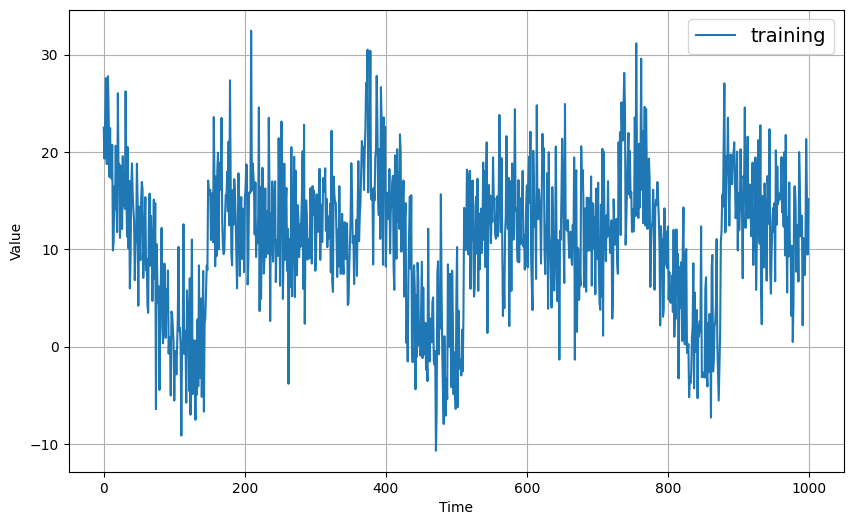

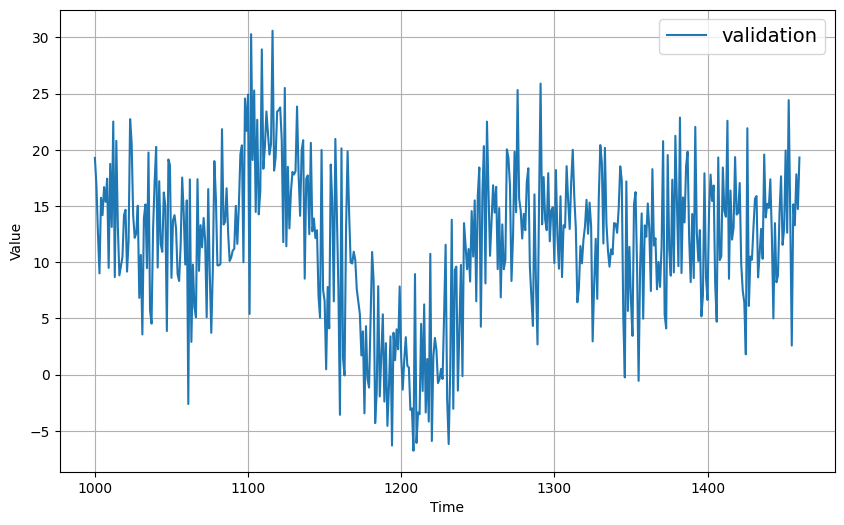

In [12]:
split_time=1000
tr_series=series[:split_time]
tr_time=time[:split_time]
val_series = series[split_time:]
val_time=time[split_time:]

plt.figure(figsize=(10, 6))
plot_Series(tr_time, tr_series,label="training")
plt.show()

plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series,label="validation")
plt.show()

Rationale: we suposse that the next value(t+1) is the current value or naive forecasting (not very reliable):

(461,)


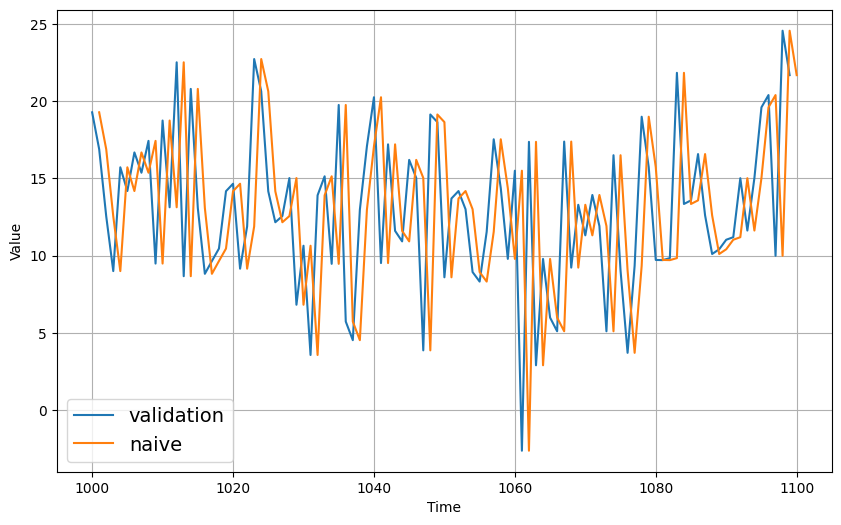

In [15]:
# copy value of day 999 until day previous of last day (1399)
naive_forecast = series[split_time - 1:-1]
print(naive_forecast.shape)
#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series,start=0,end=100, label="validation")
plot_Series(val_time, naive_forecast,start=1,end=101,label="naive")
plt.show()


## Error metrics

MAE: mean absolute error, mean absolute difference between predicted and observced

In [18]:
# manual mae
errors = naive_forecast - val_series
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print(mae)

#manual mean square error
mse = np.square(errors).mean()
print(mse)

# manual mean absolute percentage error
mape = np.abs(errors/val_series).mean()
print(mape)

# mae using keras metrics
print(tf.keras.metrics.mean_absolute_error(val_series, naive_forecast).numpy())

5.735895634779587
52.86180865873577
1.1391536007079253
5.735895634779587


# Moving average (2nd method)

Using some measures from the past as the average future (moving average window).

range(0, 1460)
range(0, 1431)
range(0, 1371)


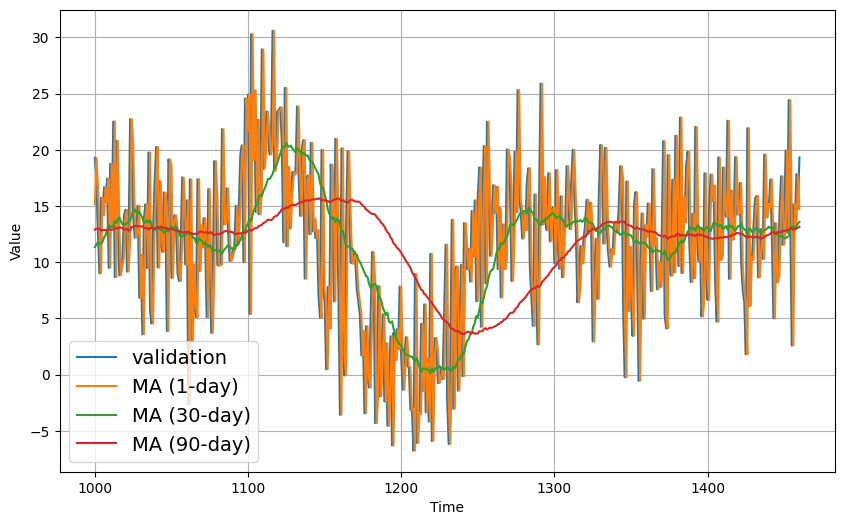

5.735895634779587
4.459605377904009


In [23]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  print(range(len(series) - window_size))
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

mv_avg=moving_average_forecast(series,1)[split_time-1:]
mv_avg2=moving_average_forecast(series,30)[split_time-30:]
mv_avg3=moving_average_forecast(series,90)[split_time-90:]

#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="validation")
plot_Series(val_time, mv_avg,label="MA (1-day)")
plot_Series(val_time, mv_avg2,label="MA (30-day)")
plot_Series(val_time, mv_avg3,label="MA (90-day)")

plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg2).numpy())

# Moving average 2: removing seasonality

Lets remove the seasonality pattern. We previously know that this is a year pattern.

(1096,)
(1096,)
(1096,)


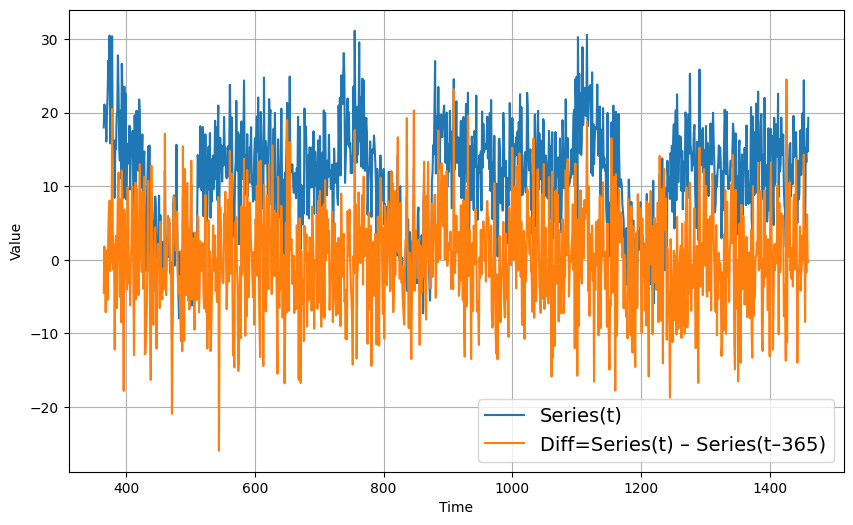

In [25]:
#using differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
print(series[:-365].shape)
print(diff_time.shape)
print(series[365:].shape)
plt.figure(figsize=(10, 6))
plot_Series(diff_time, series[365:], label="Series(t)")
plot_Series(diff_time, diff_series, label="Diff=Series(t) – Series(t–365)")
plt.show()

range(0, 1046)
461
(1096,)


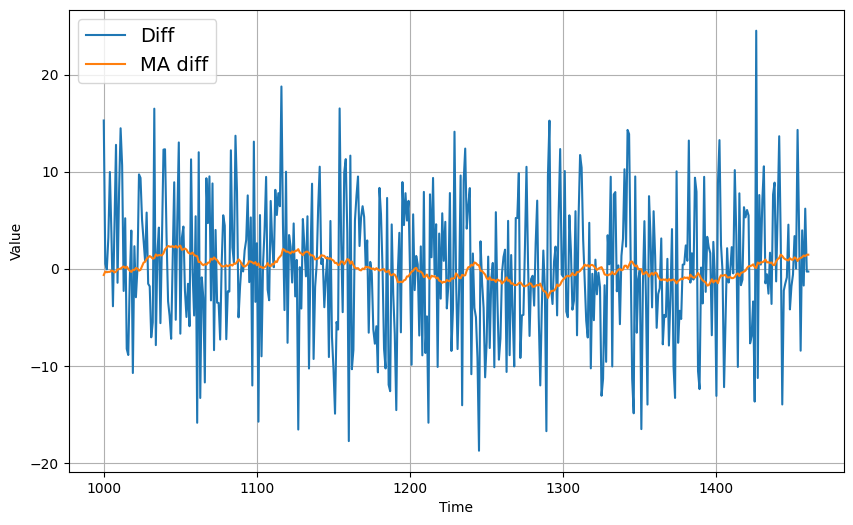

5.735895634779587
12.035387710632152


In [48]:
#remember to substract 365 to the split_time
diff_mv_avg=moving_average_forecast(diff_series,50)[split_time-365-50:]
print(len(diff_mv_avg))
print(diff_series.shape)
#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, diff_series[split_time-365:], label="Diff")
plot_Series(val_time, diff_mv_avg,label="MA diff")
plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(val_series, diff_mv_avg).numpy())



(461,)
(461,)


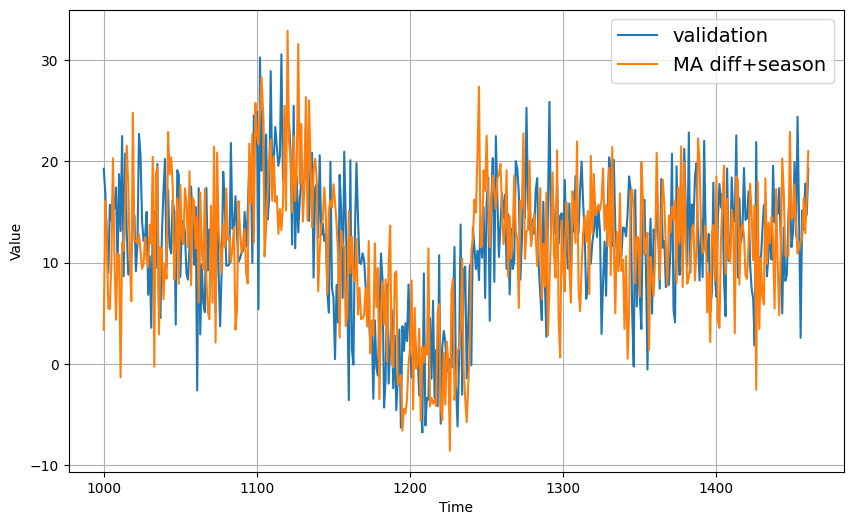

5.839310562995894


In [49]:
#bring back seasonality
print(mv_avg3.shape)
mv_avg3_ss=diff_mv_avg+series[split_time-365:-365]
print(diff_mv_avg.shape)
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="validation")
plot_Series(val_time, mv_avg3_ss,label="MA diff+season")
plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg3_ss).numpy())

Let's use the moving average of past to add to the diff moving average:

range(0, 461)


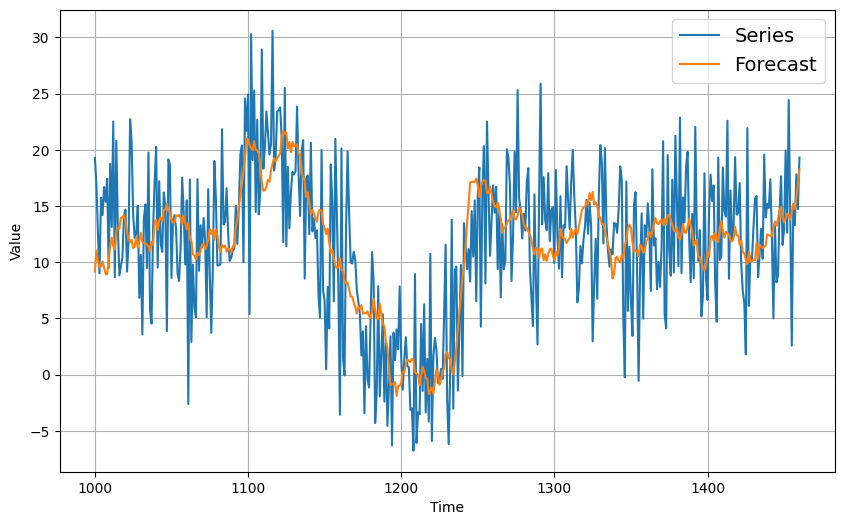

4.215717179734759


In [51]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_mv_avg

plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, diff_moving_avg_plus_smooth_past, label="Forecast")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, diff_moving_avg_plus_smooth_past).numpy())

# Machine learning

## Pre-processing using Time Windows

First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [52]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # because slicing at the end might causes different size for batches,
    # we keep batch the same size (window_size) with drop_remainder=True
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert list to tensors, the format TF likes
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # we shuffle batches to create induce IID
    dataset = dataset.shuffle(shuffle_buffer)
    # we split tensors in input and targets (last element of the tensor)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # preparing one batch in parallel using prefetch
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Linear model

In [56]:
window_size=30
#convert time series arrays to tf train dataset
train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


Epoch 1/200
31/31 [==============================] - 1s 2ms/step - loss: 18.6758 - mae: 19.1706 - lr: 1.0000e-06
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 17.7606 - mae: 18.2563 - lr: 1.0798e-06
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 16.7229 - mae: 17.2180 - lr: 1.1659e-06
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 15.6267 - mae: 16.1207 - lr: 1.2589e-06
Epoch 5/200
31/31 [==============================] - 0s 1ms/step - loss: 14.5073 - mae: 15.0001 - lr: 1.3594e-06
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 13.3884 - mae: 13.8828 - lr: 1.4678e-06
Epoch 7/200
31/31 [==============================] - 0s 1ms/step - loss: 12.2745 - mae: 12.7677 - lr: 1.5849e-06
Epoch 8/200
31/31 [==============================] - 0s 2ms/step - loss: 11.1859 - mae: 11.6775 - lr: 1.7113e-06
Epoch 9/200
31/31 [==============================] - 0s 1ms/step - loss: 10.2050 - mae: 10.6991 

(1e-06, 0.01, 0.0, 20.0)

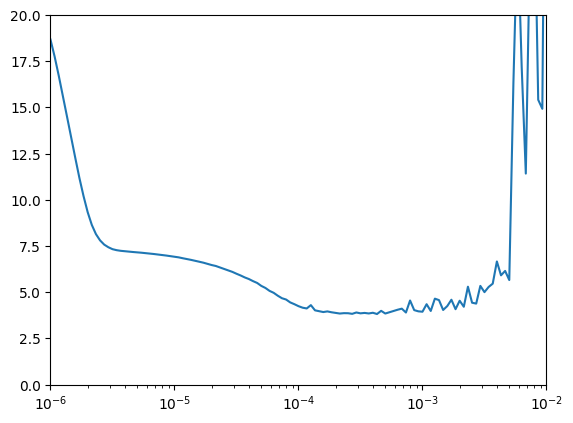

In [57]:
#clear keras backend and set seed for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# one neuron model
model1=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size]) # size of the window that used to split previously
])

# dynamic learning rate
#start with a very small learning rate (16-6), and multiply by ten each 30 epochs
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-6 * 10**(epoch/30))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

model1.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
history1=model1.fit(train_set,epochs=200,callbacks=[lr_schedule])
plt.semilogx(history1.history["lr"], history1.history["loss"],label="learning vs loss")
plt.axis([1e-6, 1e-2, 0, 20])


Based on the plot we can see it is stable up to 10e-4.

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# one neuron model
model1=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size]) # size of the window that used to split previously
])

# used the optimized learning rate
optm=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model1.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
model1.fit(train_set,epochs=200,
           validation_data=val_set,
           callbacks=[early_stop])

Epoch 1/200
31/31 [==============================] - 1s 10ms/step - loss: 7.7753 - mae: 8.2627 - val_loss: 6.4164 - val_mae: 6.9016
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 6.1086 - mae: 6.5912 - val_loss: 5.9590 - val_mae: 6.4437
Epoch 3/200
31/31 [==============================] - 0s 4ms/step - loss: 5.6872 - mae: 6.1656 - val_loss: 5.5356 - val_mae: 6.0163
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 5.4273 - mae: 5.9074 - val_loss: 5.3568 - val_mae: 5.8400
Epoch 5/200
31/31 [==============================] - 0s 4ms/step - loss: 5.1838 - mae: 5.6635 - val_loss: 5.1213 - val_mae: 5.6045
Epoch 6/200
31/31 [==============================] - 0s 7ms/step - loss: 4.9460 - mae: 5.4247 - val_loss: 4.9487 - val_mae: 5.4330
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 4.7521 - mae: 5.2290 - val_loss: 4.7932 - val_mae: 5.2760
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 4.6711 - 

In [59]:
def nn_forecast(model,series,ws):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(ws, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(ws))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)
  return forecast
lin_forecast = nn_forecast(model1, series[split_time - window_size:-1], window_size)[:, 0]
lin_forecast.shape

15/15 [==============================] - 0s 4ms/step


(461,)

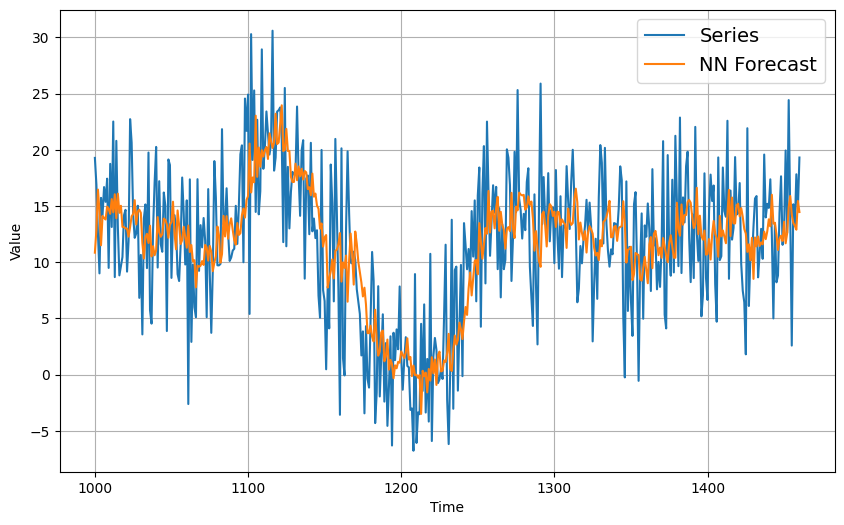

4.2959676


In [61]:
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, lin_forecast, label="NN Forecast")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, lin_forecast).numpy())

## Dense model

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 7.4319 - mae: 7.9178 - val_loss: 20.9732 - val_mae: 21.4728 - lr: 1.0000e-07
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4288 - mae: 7.9147 - val_loss: 20.9565 - val_mae: 21.4561 - lr: 1.1220e-07
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.4250 - mae: 7.9109 - val_loss: 20.9386 - val_mae: 21.4383 - lr: 1.2589e-07
Epoch 4/500
31/31 [==============================] - 1s 15ms/step - loss: 7.4208 - mae: 7.9067 - val_loss: 20.9174 - val_mae: 21.4170 - lr: 1.4125e-07
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 7.4160 - mae: 7.9019 - val_loss: 20.8935 - val_mae: 21.3932 - lr: 1.5849e-07
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 7.4107 - mae: 7.8966 - val_loss: 20.8675 - val_mae: 21.3672 - lr: 1.7783e-07
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4048 - mae: 7.8907 - 

(1e-07, 0.01, 0.0, 20.0)

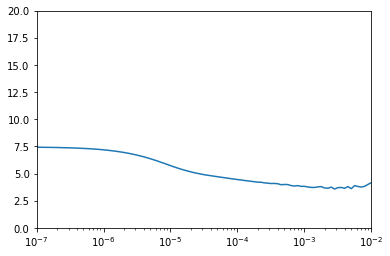

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# hidden layers model
model2=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]), # size of the window that used to split previously
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)
])

# dynamic learning rate not needed because we already figure it out
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-7 * 10**(epoch/20))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
# early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model2.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
history2=model2.fit(train_set,epochs=500,
           validation_data=val_set,
           callbacks=[lr_schedule])

plt.semilogx(history2.history["lr"], history2.history["loss"],label="learning vs loss")
plt.axis([1e-7, 1e-2, 0, 20])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# hidden layers model
model2=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]), # size of the window that used to split previously
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)
])

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model2.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
model2.fit(train_set,epochs=500,
           validation_data=val_set,
           callbacks=[early_stop])

Epoch 1/500
31/31 [==============================] - 2s 20ms/step - loss: 5.2970 - mae: 5.7787 - val_loss: 4.6577 - val_mae: 5.1404
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1926 - mae: 4.6695 - val_loss: 4.8092 - val_mae: 5.2878
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0323 - mae: 4.5082 - val_loss: 4.9994 - val_mae: 5.4790
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9344 - mae: 4.4063 - val_loss: 4.2933 - val_mae: 4.7751
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 3.8184 - mae: 4.2890 - val_loss: 4.1472 - val_mae: 4.6197
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 3.7845 - mae: 4.2581 - val_loss: 4.2482 - val_mae: 4.7299
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 3.7713 - mae: 4.2441 - val_loss: 4.0305 - val_mae: 4.5073
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 3.7306 - 

15/15 [==============================] - 15s 7ms/step


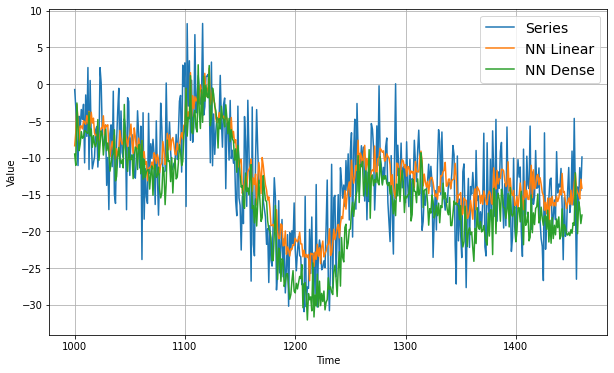

4.954004


In [ ]:
den_forecast = nn_forecast(model2, series[split_time - window_size:-1], window_size)[:, 0]
den_forecast.shape
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, lin_forecast, label="NN Linear")
plot_Series(val_time, den_forecast, label="NN Dense")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, den_forecast).numpy())